In [4]:
import csv 
import numpy as np
import pandas as pd
import sys
import platform
system = platform.system()
if system =='Linux':
    sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
elif system =='Darwin':
    sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
from battery import OCVcurve, Thevenin
import analog
from scipy.interpolate import interp1d as interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
path2curve = 'Battery 9 (RIP)/Discharge 200mA/SOCvsOCV_discharge200mA.csv'
curve = OCVcurve(path2curve)

### Import the test file

In [25]:
if system == 'Linux':
    folder = '/home/lucas/Documents/Log_Analysis/Logs/KF Testing/Donald Trump/Both'
elif system == 'Darwin':
    folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs/KF Testing/H3/Both'
    
log_file = analog.pathfromQGC(folder,index=131)

print(log_file)
info = analog.logextract(log_file,['battery_status','battery_status_ekf','vehicle_local_position'])
print(info.keys())

# From battery_status
current = info['battery_current']
current_filtered = info['battery_filtered_current']
SOC = info['remaining']
time = info['time_bs']
time_ekf = info['time_bkf']
n_cells = info['n_cells']
voltage = info['battery_voltage']/n_cells
# From battery_status_ekf
SOC_ekf = info['remaining_ekf']
kalman_gain = info['kalman_gain']
kalman_gain = np.squeeze(kalman_gain)
covar_x = info['covx']
covar_w = info['covw']
innovation = info['innovation']
iR1 = info['iR1']

# discard timestamps with non-initalized battery
current = current[voltage>0]
current_filtered = current_filtered[voltage>0]
SOC = SOC[voltage>0]
time = time[voltage>0]
# kalman_gain = kalman_gain[:,voltage>0]
# covar_x = covar_x[:,:,voltage>0]
# innovation = innovation[voltage>0]
# iR1 = iR1[voltage>0]
voltage = voltage[voltage>0] # to be done at the end
print(len(time))

# # From vehicle_local_position
# x = info['x']
# y = info['y']
# z = info['z']
# time_vlp = info['time_vlp']

/home/lucas/Documents/Log_Analysis/Logs/KF Testing/Donald Trump/Both/log_131_2019-12-16-14-38-18.ulg
dict_keys(['time_vlp', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'time_bkf', 'remaining_ekf', 'covx', 'covw', 'kalman_gain', 'innovation', 'iR1', 'time_bs', 'n_cells', 'battery_current', 'battery_filtered_current', 'battery_voltage', 'battery_filtered_voltage', 'discharged_mah', 'remaining'])
102


# Kalman filter analysis

<IPython.core.display.Javascript object>


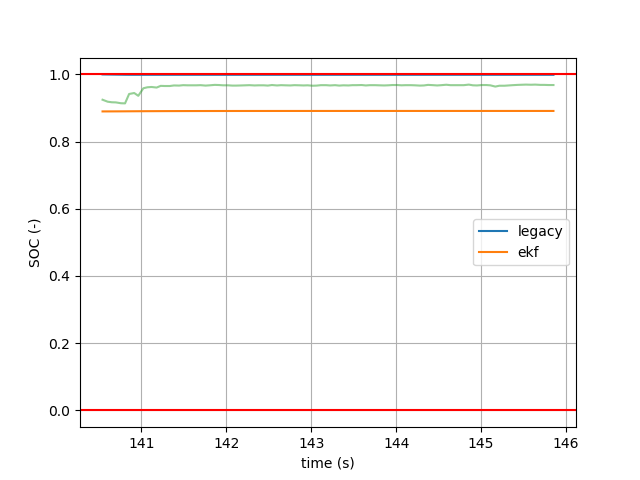

In [26]:
%matplotlib notebook
plt.figure()
plt.plot(time,SOC,label='legacy')
plt.plot(time_ekf,SOC_ekf,label='ekf')
plt.plot(time,voltage/4.35,alpha=0.5)
plt.xlabel('time (s)')
plt.ylabel('SOC (-)')
plt.axhline(0,color='r')
plt.axhline(1,color='r')
#plt.plot(time,current/current[0],alpha=.7)
plt.grid()
plt.legend()
plt.show()

In [22]:
print(time[0])
print(time_ekf[0])

891.789587
891.789443


# Simulation


In [10]:
ECparams = pd.read_csv('ECparams.csv')
R0 = float(ECparams['R0'])
R0 = 0.01
R1 = float(ECparams['R1'])
R1 = 0.005
C1 = float(ECparams['C1'])
C1 = 500
print([R0,R1,C1])

[0.01, 0.005, 500]


### Tune some more simulation parameters

In [11]:
Q = 6500*3.6 # has to be in Coulombs
eta = 1
z0 = SOC_ekf[0]
print(f'z0 = {z0}')
battery = Thevenin(z0,Q,curve,R0,R1,C1)

z0 = 0.9306026697158813


### Run the simulation using the state-space model

In [12]:
xhat0 = np.array([[SOC[0]],[iR1[0]]]) # is a stack of 2x1 arrays = a 2xk array
covx0 = covar_x[:,:,0]
#covx0 = np.array([[0.1,0.],[0., 0.]]) # is a stack of 2x2 arrays

#covw = np.array([[1e-3, 0.],[0., 1e-4]]) # is a constant 2x2 array
covw = covar_w[:,:,0]
step=1
u = current[slice(1,len(current),step)] # is a stack of 1x1 arrays = a 1-D array
y = voltage[slice(1,len(voltage),step)] # is a stack of 1x1 arrays = a 1-D array

kfbat = Thevenin(z0,Q,curve,R0,R1,C1)

In [13]:
xhat,covx,yhat,L = kfbat.kfrun(time,u,y,covw=covw,covx0=covx0)
print(np.shape(xhat))

(2, 138)


## Comparison of Kalman filter results with firmware ones

<IPython.core.display.Javascript object>


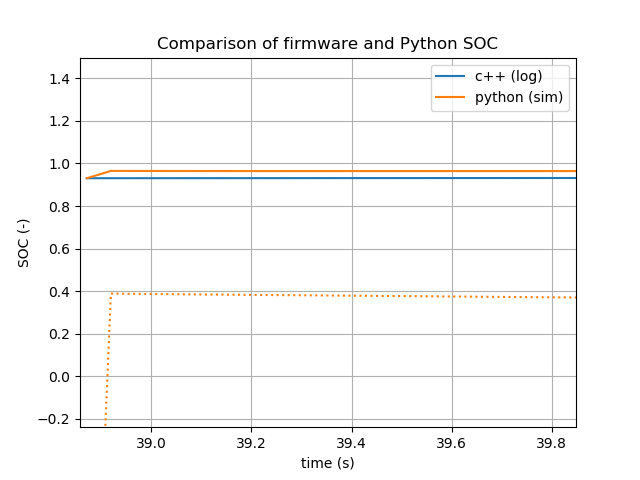

In [14]:
n=len(time)
plt.figure()
plt.plot(time_ekf,SOC_ekf,label='c++ (log)')
plt.plot(time_ekf,SOC_ekf+covar_x[0,0,:],linestyle=':',color='C0')
plt.plot(time_ekf,SOC_ekf-covar_x[0,0,:],linestyle=':',color='C0')
plt.plot(time[slice(0,n-1,step)],xhat[0,:],label='python (sim)')
plt.plot(time[slice(0,n-1,step)],xhat[0,:]+covx[0,0,:],linestyle=':',color='C1')
plt.plot(time[slice(0,n-1,step)],xhat[0,:]-covx[0,0,:],linestyle=':',color='C1')
plt.xlabel('time (s)')
plt.ylabel('SOC (-)')
plt.legend()
plt.grid()
plt.title('Comparison of firmware and Python SOC')
plt.show()

When downsampling the current and the voltage measurements, the steepness of the rise to the correct/likely value of SOC is lower. I think that is due to the limit on innovation.

In [ ]:
plt.figure()
plt.plot(time,iR1,label='c++ (log)')
plt.plot(time[slice(1,n,step)],xhat[1,:],label='python (sim)')
plt.xlabel('time (s)')
plt.ylabel('iR1 (-)')
plt.legend()
plt.title('Comparison of firmware and Python iR1')
plt.grid()

In [ ]:
plt.figure()
plt.plot(time,innovation,label='c++ (log)')
plt.plot(time[slice(1,n,step)],y-yhat,label='python (sim)')
plt.xlabel('time (s)')
plt.ylabel('innovation (-)')
plt.legend()
plt.grid()
plt.title('Comparison of firmware and Python innovation')

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(time,kalman_gain[0,:],label='c++ (log)')
plt.plot(time[slice(1,n,step)],L[0,:],label='python (sim)')
plt.grid()
plt.ylabel('K0 (-)')
plt.title('Comparison of firmware and Python Kalman Gain')
plt.subplot(212)
plt.plot(time,kalman_gain[1,:],label='c++ (log)')
plt.plot(time[slice(1,n,step)],L[1,:],label='python (sim)')
plt.xlabel('time (s)')
plt.ylabel('K1 (-)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
np.mean(np.diff(time))